# Required libraries


In [287]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import skimage.data
import skimage.transform
from skimage.transform import resize
from skimage.color import rgb2gray
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score

# Loading Data

In [288]:
def loading_data(data_dir):

    images= []
    labels = []
    categroies = [c for c in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, c))]
    for c in categroies:
        path = os.path.join (data_dir ,c)
        data=  [os.path.join(path, f) 
                    for f in os.listdir(path)if f.endswith(".ppm")]         
        for f in data:
            images.append(cv2.imread(f))
            labels.append(int(c))
    return images , labels

cur_path = (r"C:\Users\Youmna Ramadan\Desktop\pr_project")  
train_data = os.path.join(cur_path ,"Training")
test_data = os.path.join(cur_path, "Testing")

images, labels = loading_data(train_data)
test_images, test_labels = loading_data(test_data) 



In [289]:

print("train images: ", len(images),"\nlabel: ",len(labels),"\nclass: ",len(set(labels)))


train images:  4575 
label:  4575 
class:  62


# Data Shape

In [290]:
for image in images[:10]:
    print("shape: ", image.shape ,",min:" , image.min()  ,",max:",image.max())

shape:  (141, 142, 3) ,min: 0 ,max: 255
shape:  (120, 123, 3) ,min: 0 ,max: 255
shape:  (105, 107, 3) ,min: 0 ,max: 255
shape:  (94, 105, 3) ,min: 7 ,max: 255
shape:  (128, 139, 3) ,min: 0 ,max: 255
shape:  (110, 118, 3) ,min: 8 ,max: 255
shape:  (85, 95, 3) ,min: 0 ,max: 255
shape:  (180, 193, 3) ,min: 0 ,max: 255
shape:  (121, 133, 3) ,min: 0 ,max: 255
shape:  (81, 88, 3) ,min: 10 ,max: 255


# Display Training Images

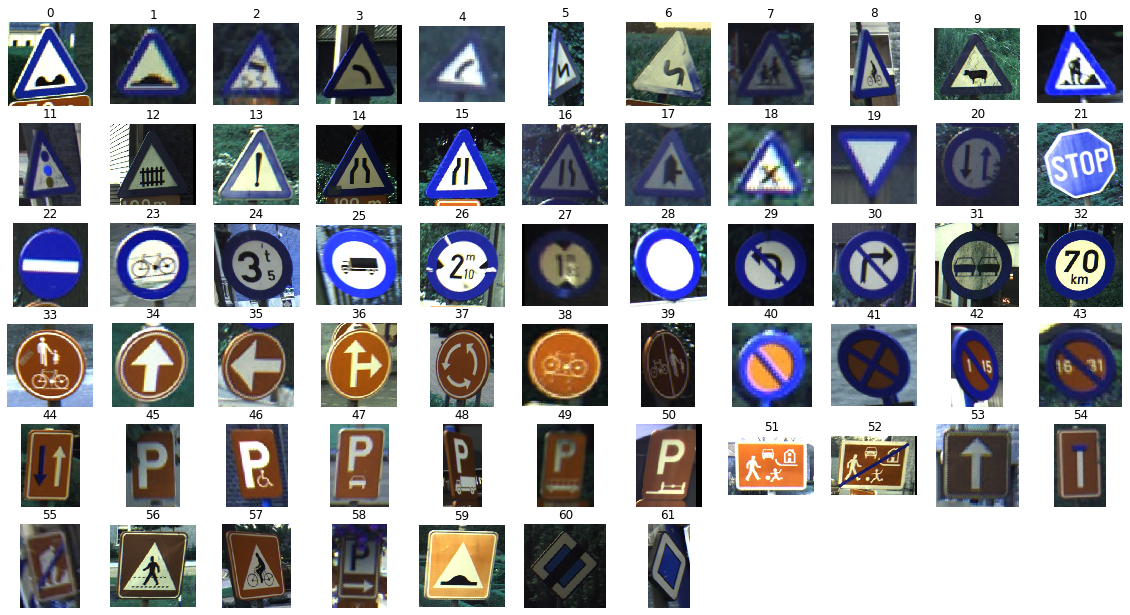

In [291]:
def display_images(images,labels):
     plt.figure(figsize=(20, 20))
     classes = set(labels)
     i = 1
     for label in classes:
         image = images[labels.index(label)]
         plt.subplot(11,11,i)
         plt.axis('off')
         plt.title(label)   
         plt.imshow(image) 
         i = i+1
     plt.show()  
display_images(images,labels)


# Preprocessing Images

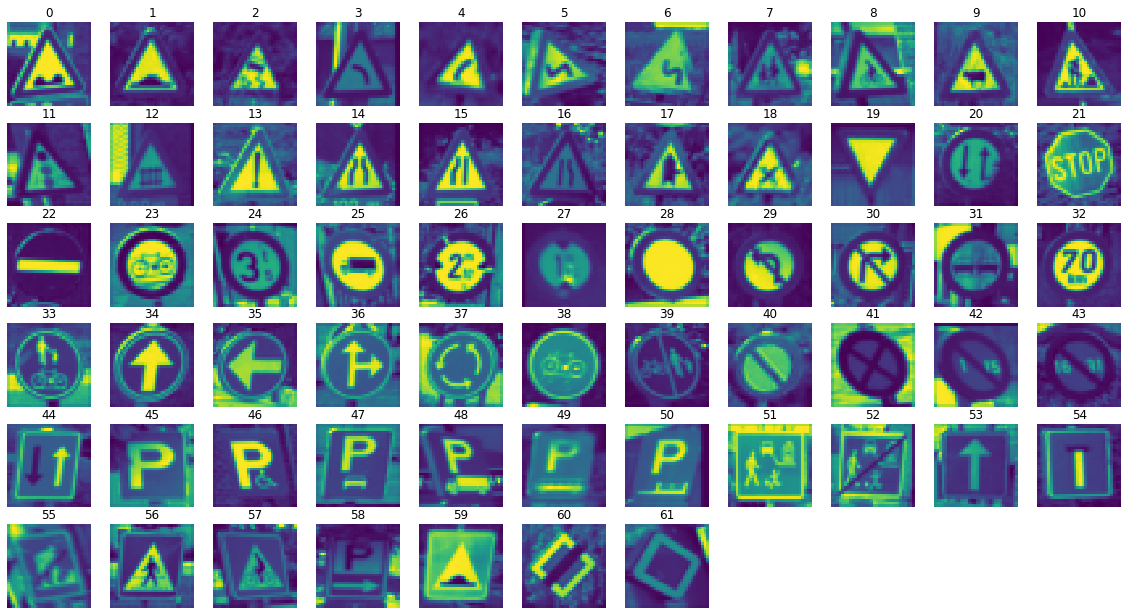

In [292]:
#------train images preprocessing------
images32 = [resize(image, (32, 32), mode='constant')
                for image in images]
gray = [rgb2gray(image)
                for image in images32]
    
display_images(gray, labels)


In [293]:
for image in gray[:10]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (32, 32), min: 0.05806074812346815, max: 0.994664705882353
shape: (32, 32), min: 0.054914788602941085, max: 0.9957956862745099
shape: (32, 32), min: 0.05363333362055762, max: 0.9954201654411765
shape: (32, 32), min: 0.07024291647518385, max: 0.8978748839613971
shape: (32, 32), min: 0.06902095894607843, max: 0.8890038235294118
shape: (32, 32), min: 0.08669140969669102, max: 0.9051254166666667
shape: (32, 32), min: 0.054221039081648305, max: 0.9321512267348345
shape: (32, 32), min: 0.010150399050245163, max: 0.8500424272365197
shape: (32, 32), min: 0.05536332892922788, max: 0.9806950099571081
shape: (32, 32), min: 0.1181541681985295, max: 0.9959365065870098


In [294]:
#------test images preprocessing------
images_32 = [resize(image, (32, 32), mode='constant')
                for image in test_images]
gray2 = [rgb2gray(image)
                for image in images_32]

In [295]:
x_train = np.array(gray)
y_train = np.array(labels)
x_test = np.array(gray2)
y_test = np.array(test_labels)
print( x_train.shape)
print( y_train.shape)
print(x_test.shape)
print(y_test.shape)

(4575, 32, 32)
(4575,)
(2520, 32, 32)
(2520,)


In [296]:
x_train = x_train.reshape(4575, 32*32)
x_test = x_test.reshape(2520,32*32)

In [297]:
with tf.compat.v1.Session() as sess:
    y_train = sess.run(tf.one_hot(y_train , 62))
    y_test = sess.run(tf.one_hot(y_test, 62 ))
sess.close()

In [298]:
print( x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(4575, 1024)
(4575, 62)
(2520, 1024)
(2520, 62)


# Define hyperparameters

In [299]:
learning_rate = 1.0
epochs = 700
batch_size = 1000
batches = int(x_train.shape[0] / batch_size)

# Create Model


In [300]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

X = tf.placeholder(tf.float32, [None, 1024])
Y = tf.placeholder(tf.float32, [None, 62])

W = tf.Variable(tf.truncated_normal([1024, 62]))
B = tf.Variable(tf.zeros(62))


In [301]:
#Declare model
model_output = tf.matmul(X, W) + B

In [302]:
#Loss Function 
alpha = tf.constant([0.00001])
delta = tf.constant([1.0], tf.float32)

regulation_term = alpha * tf.nn.l2_loss(W) 

S_truelabel = tf.reduce_sum(tf.multiply(Y,model_output),axis=1 ,keepdims=True)
loss = tf.reduce_mean(tf.reduce_sum(tf.maximum(0.0, model_output - S_truelabel + delta), 1) - delta )
loss += regulation_term

In [303]:
#Optimizer for minimize loss 
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [304]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

epoch:0 loss=[1187.8026] Acc=23.1
epoch:1 loss=[624.1953] Acc=23.1
epoch:2 loss=[278.70306] Acc=23.1
epoch:3 loss=[74.1802] Acc=30.3
epoch:4 loss=[137.59547] Acc=21.9
epoch:5 loss=[54.396606] Acc=44.3
epoch:6 loss=[27.718637] Acc=63.8
epoch:7 loss=[20.263824] Acc=55.0
epoch:8 loss=[31.114067] Acc=40.6
epoch:9 loss=[32.525116] Acc=40.9
epoch:10 loss=[44.666805] Acc=55.6
epoch:11 loss=[35.141327] Acc=39.2
epoch:12 loss=[32.731926] Acc=82.0
epoch:13 loss=[41.230213] Acc=75.6
epoch:14 loss=[31.080086] Acc=76.9
epoch:15 loss=[5.3167825] Acc=91.2
epoch:16 loss=[1.1809156] Acc=92.0
epoch:17 loss=[0.9870883] Acc=93.2
epoch:18 loss=[0.9348267] Acc=94.0
epoch:19 loss=[0.89120793] Acc=94.3
epoch:20 loss=[0.94482744] Acc=94.0
epoch:21 loss=[0.9002304] Acc=94.3
epoch:22 loss=[0.85468376] Acc=94.3
epoch:23 loss=[0.81675243] Acc=94.4
epoch:24 loss=[0.78063637] Acc=95.0
epoch:25 loss=[19.889746] Acc=94.7
epoch:26 loss=[27.276701] Acc=94.5
epoch:27 loss=[29.935934] Acc=94.7
epoch:28 loss=[20.282682] Ac

epoch:230 loss=[2.0022316] Acc=83.3
epoch:231 loss=[1.2972484] Acc=88.3
epoch:232 loss=[2.3489628] Acc=81.5
epoch:233 loss=[1.9108243] Acc=83.8
epoch:234 loss=[6.053314] Acc=82.6
epoch:235 loss=[21.223017] Acc=77.2
epoch:236 loss=[27.451244] Acc=76.7
epoch:237 loss=[17.468042] Acc=81.4
epoch:238 loss=[4.1294603] Acc=75.9
epoch:239 loss=[3.7002692] Acc=76.0
epoch:240 loss=[3.5197525] Acc=75.8
epoch:241 loss=[6.0362177] Acc=68.5
epoch:242 loss=[11.301557] Acc=56.5
epoch:243 loss=[28.88494] Acc=36.6
epoch:244 loss=[129.12166] Acc=20.2
epoch:245 loss=[53.513756] Acc=32.7
epoch:246 loss=[78.82143] Acc=28.9
epoch:247 loss=[33.95604] Acc=55.7
epoch:248 loss=[24.521828] Acc=62.8
epoch:249 loss=[10.4093895] Acc=64.9
epoch:250 loss=[9.966952] Acc=64.6
epoch:251 loss=[6.057239] Acc=72.3
epoch:252 loss=[6.2986426] Acc=71.0
epoch:253 loss=[8.061721] Acc=65.8
epoch:254 loss=[13.061436] Acc=55.8
epoch:255 loss=[16.973818] Acc=50.4
epoch:256 loss=[19.382736] Acc=55.7
epoch:257 loss=[29.604113] Acc=67.

epoch:459 loss=[0.7785789] Acc=94.6
epoch:460 loss=[0.78265977] Acc=94.6
epoch:461 loss=[0.7921223] Acc=94.0
epoch:462 loss=[10.348525] Acc=93.9
epoch:463 loss=[16.546103] Acc=93.8
epoch:464 loss=[18.060574] Acc=93.4
epoch:465 loss=[5.368658] Acc=93.2
epoch:466 loss=[3.407528] Acc=79.0
epoch:467 loss=[1.1128318] Acc=90.1
epoch:468 loss=[1.0981971] Acc=90.4
epoch:469 loss=[1.1305356] Acc=89.8
epoch:470 loss=[1.0765008] Acc=90.3
epoch:471 loss=[1.2523115] Acc=88.4
epoch:472 loss=[1.357038] Acc=87.2
epoch:473 loss=[1.2475703] Acc=87.6
epoch:474 loss=[1.3181047] Acc=87.5
epoch:475 loss=[1.4224117] Acc=86.9
epoch:476 loss=[1.3088367] Acc=87.5
epoch:477 loss=[1.131274] Acc=89.0
epoch:478 loss=[1.073373] Acc=89.5
epoch:479 loss=[1.0885859] Acc=89.1
epoch:480 loss=[1.3362709] Acc=86.6
epoch:481 loss=[1.2478725] Acc=87.6
epoch:482 loss=[1.0931711] Acc=88.5
epoch:483 loss=[0.9892838] Acc=90.3
epoch:484 loss=[1.0501864] Acc=89.0
epoch:485 loss=[0.8555136] Acc=91.5
epoch:486 loss=[0.8594936] Acc=9

epoch:687 loss=[0.7705374] Acc=94.7
epoch:688 loss=[0.7655806] Acc=94.5
epoch:689 loss=[0.7600634] Acc=94.8
epoch:690 loss=[0.7915988] Acc=94.5
epoch:691 loss=[0.77647084] Acc=94.5
epoch:692 loss=[0.786003] Acc=94.2
epoch:693 loss=[0.7811588] Acc=95.1
epoch:694 loss=[0.77683115] Acc=94.2
epoch:695 loss=[0.7722884] Acc=95.0
epoch:696 loss=[0.7610889] Acc=95.4
epoch:697 loss=[0.76245034] Acc=94.7
epoch:698 loss=[0.7601802] Acc=95.1
epoch:699 loss=[0.748919] Acc=95.2
Test Accuracy =  68.53174603174604


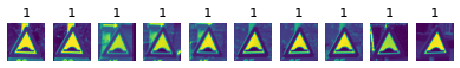

In [305]:
#-------------------Train the model--------------

with tf.Session() as sesh:
    sesh.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        for i in range(batches):
            offset = i * epoch
            x = x_train[offset: offset + batch_size]
            y = y_train[offset: offset + batch_size]
            sesh.run(optimizer, feed_dict={X: x, Y:y})
            c = sesh.run(loss, feed_dict={X:x, Y:y})
            
        if epoch % 1 == 0 :
            acc = accuracy(sesh.run(model_output,feed_dict={X: x, Y:y}), y)
            print(f'epoch:{epoch} loss={c} Acc={acc}')
            
#-------------------Test the model--------------

    print('Test Accuracy = ', accuracy(sesh.run(model_output,feed_dict={X: x_test, Y:y_test}),y_test))    
    fig, axes = plt.subplots(1, 10, figsize=(8, 4))
    for img, ax in zip(x_test[10:20], axes):
        guess = np.argmax(sesh.run(model_output, feed_dict={X: [img]}))
        ax.set_title(guess)
        ax.imshow(img.reshape((32, 32)))
        ax.axis('off')
        
    y_pred = (sesh.run(model_output,feed_dict={X: x_test}))  

# Confusion matrix

In [306]:
y_pred = np.argmax(y_pred,axis=1)
y_test =np.argmax(y_test,axis=1)
results = confusion_matrix(y_test,y_pred)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_test, y_pred.round(), normalize=False))
print ('Report : ')
print (classification_report(y_test, y_pred) )

Confusion Matrix :
[[ 1  5  0 ...  0  0  0]
 [ 0 26  0 ...  0  0  0]
 [ 0  0  1 ...  0  0  0]
 ...
 [ 0 13  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
Accuracy Score : 1727
Report : 
              precision    recall  f1-score   support

           0       0.25      0.17      0.20         6
           1       0.58      0.96      0.72        27
           2       1.00      0.14      0.25         7
           3       0.00      0.00      0.00         6
           4       0.08      0.08      0.08        12
           5       0.33      0.33      0.33         3
           6       0.67      0.67      0.67         6
           7       0.82      0.88      0.85        90
           8       0.27      0.83      0.41        12
           9       0.00      0.00      0.00         0
          10       0.93      0.50      0.65        28
          11       0.00      0.00      0.00         0
          12       0.20      0.33      0.25         3
          13       0.47      0.44   